# Step-by-step procedures to obtain the 2D rotational projected density map from 3D EB1-GFP comet
The comet data used in this work were from the experiment carried out in [Chen et al.2014](http://science.sciencemag.org/content/346/6208/1257998), detected using technique as in [Yamashita et al.2015](https://www.spiedigitallibrary.org/journals/Journal-of-Biomedical-Optics/volume-20/issue-10/101206/Three-dimensional-tracking-of-plus-tips-by-lattice-light-sheet/10.1117/1.JBO.20.10.101206.full?SSO=1) 


# Import library and custom function
*this note and custom function are created based on Python 2. If you are use python 3, some function such as 'print' has to be changed.

In [1]:
import numpy as np
import sys,math,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib as mpl
from functionlist import * #(refer to functionlist.py for detail)

# Import comet spots
Comet spots data for a particular cell stored in /folder/ are loaded and plotted.

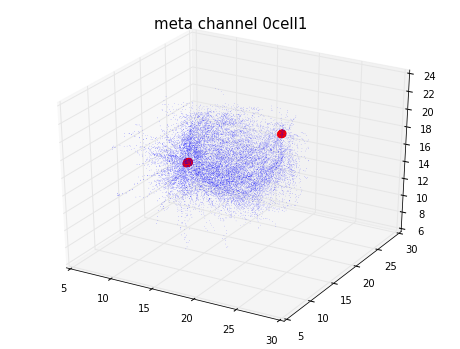

In [2]:
%matplotlib inline
spot,cent=importspots(types='meta',channel=0,cell=1,plot=True) 

# Rotate 3D spots onto 2D plane
Coordinates of comets and centrosomes are transformed such that spindle axis (vector connecting the two centrosomes) aligned with the x-axis. 
Then, all comet points were rotated around the x-axis and projected onto an arbitary 2D plane with its normal vector orthogonal to the spindle axis.


('time frame=', 75)


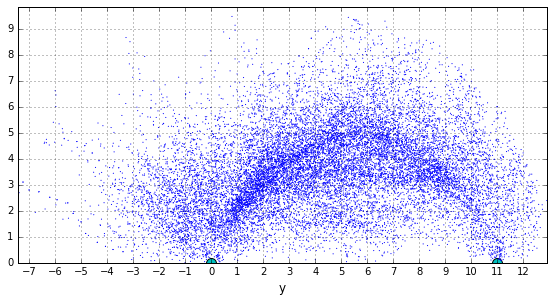

In [3]:
#rotate given 3D comet and centrosomes coordinate,
#return rotated comet spots (sx,sy) and centrosome (C1,C2)
sx,sy,C1,C2,tf=rotatespots(spot,cent,True)
print('time frame=', tf)


# Rescale x-coordinate and create grid
Before assembling comet spots from all cells, the x coordinates of 2D commets were rescaled such that inter-centrosomal distance is one. 
Following that, a regular 2D grid covering all comet spots was created. 

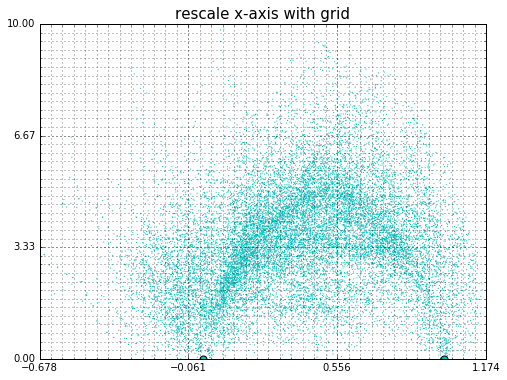

In [4]:
X=sx/C2[0] #rescale x coordinate
Y=sy
c1=C1
c2=C2/C2[0]
num = 40 #number of grid in each x and y-axis
xed,yed=plotfig(X,Y,c1,c2,num,True)

# Number of spots in each grid
The number of comets in each grid element was counted.
Interpolated density values of in-between grid elements were color-coded.

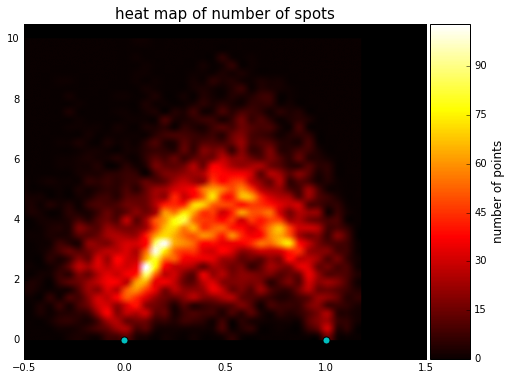

In [5]:
H=numberofspot(X,Y,c1,c2,xed,yed,True)

# Number of spots to density
Comet density of each grid element was calculated by normalizing the number of comets
with: 

### i) 3D volume corresponding to each grid element 
The volume is a function of distance from the spindle axis and can be expressed as 
$$\begin{equation}
v=2\pi h w(2n-1)
\end{equation}
$$
where $n=1,2,3,...,N_y$, 
with $N_y$ representing the total number of grid elements perpendicular to the
spindle axis. $w$ and $h$ are the width and height of the elements, respectively.

### (ii) Total density of all grid
such that the summed density of all elements is one.

Because the centrosomes have much higher densities relative to other regions, we imposed an upper cut-off color value to better illustrate the density variation of non-centrosomal regions.

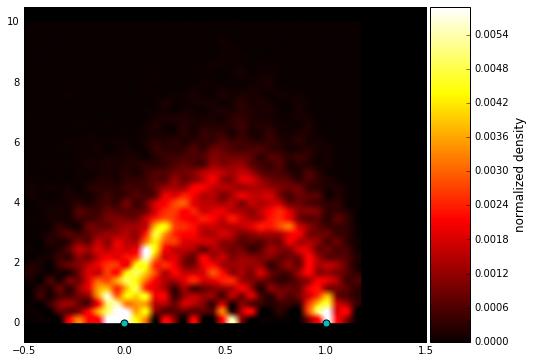

In [6]:
nH=Ndensity(H,xed,yed,c1,c2,1,num,True)

# Bulk process
Here, we collect the rotated comets spots for all cells at prometaphase and metaphase stages.
At the end we have two set of data, the prometaphase spots and the metaphase spots. 
The total duration of each types are stored.

In [7]:
typess = ['prometa','meta']
ch=0
cells = [1,2,3]
spotdata = []
dts=0.755#time duration of each frame
totduration=[]

for types in typess:
    print('types=',types)
    xs = np.array([])
    ys = np.array([])
    #if types=='control': cellist=controlcell
    #else: cellist=apccell
    totdur=0
    #for ch in channels:
    #print('channel=',ch)
    #cells= cellist[ch-1]
    for cell in cells:
        spot,cent=importspots(types,ch,cell,False)
        sx,sy,C1,C2,tf=rotatespots(spot,cent,False)
        dur = tf*dts
        print('cell',cell,' duration=',dur            )
        xs = np.r_[xs,sx/C2[0]]
        ys = np.r_[ys,sy]  
        totdur+=dur
    print('total duration in types={} is {}'.format(types,totdur))
    totduration.append(totdur)
    spotdata.append([xs,ys])


('types=', 'prometa')
('cell', 1, ' duration=', 56.625)
('cell', 2, ' duration=', 56.625)
('cell', 3, ' duration=', 56.625)
total duration in types=prometa is 169.875
('types=', 'meta')
('cell', 1, ' duration=', 56.625)
('cell', 2, ' duration=', 56.625)
('cell', 3, ' duration=', 56.625)
total duration in types=meta is 169.875


# Comet density difference in between prometaphase and metaphase stage
From the rotated spots data above, we calculate the normalized density as describe earlier. However, cell from different channel have different acquisition duration. For fair comparison, we normalized the spots density with the time duration as well. The final normalized spot density have total sum equal to one.

To better observe the difference between the prometaphase and metaphase stage. We take the difference between the normalized density of each grid element of the metaphase and prometaphase cells (metaphase-prometaphase). The result is color coded such that white indicate no difference, red indicate positive difference (higher density) and blue indicate negative difference (lower density) in the metaphase cells as compared to prometaphase cells.

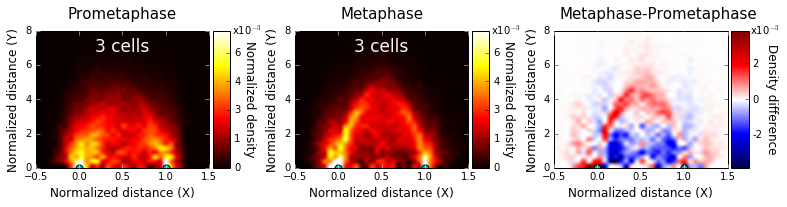

In [8]:
num = 40 #number of bin in each axis
ed=[-0.733, 1.629, 0, 10] #[xmin,xmax,ymin,ymax] of edges
graphlim=[-0.5,1.5,0,8] #x y limit of plot
vfac = 0.7 #to avoid saturation of colorrange due to high intensity at centrosome, 
#we set vmax of color plot as 0.7*the maximum density, 0 as minimum density
asp = 'auto' #aspect ratio
inter = 'spline16' #none /spline16    
clr=['b','r',None]
titles=['Prometaphase','Metaphase']
labels=['3 cells','3 cells',None]
labels2=["Normalized density","Normalized density","Density difference"]
cmaps=['hot','hot','seismic']
fig = plt.figure(1,figsize=(11,3))
gs1 = grd.GridSpec(1,3)
density = [[],[]]
#rescale centrosome positions:
c1 = [0,0]
c2 = [1,0]
xedges = np.linspace(ed[0],ed[1],num)
yedges = np.linspace(ed[2],ed[3],num)

def plotfig(normH,c1,c2,no,v):
    ax = plt.subplot(gs1[no])         
    c=clr[no]
    cmap = plt.get_cmap(cmaps[no])
    myextent  =[ed[0],ed[1],ed[2],ed[3]]
    p = ax.imshow(normH,origin='low',extent=myextent,interpolation=inter,cmap=cmap,aspect=asp,vmin=v[0],vmax=v[1])
    ax.scatter(c1[0],c1[1],s=50, c='c')
    ax.scatter(c2[0],c2[1],s=50, c='c')
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xlim(graphlim[0],graphlim[1])
    ax.set_ylim(graphlim[2],graphlim[3])
    ax.set_axis_bgcolor('black')
    ax.set_xlabel('Normalized distance (X)')
    ax.set_ylabel('Normalized distance (Y)')
    if no!=2:
        ax.text(0.5,0.85,labels[no],horizontalalignment='center',size=17,color='white',transform=ax.transAxes)
        ax.set_title(titles[no],position=(0.5,1.05))
        for tk1,tk2 in zip(ax.get_xticklines(),ax.get_yticklines()):
            tk1.set_color('white')
            tk2.set_color('white')        
    else:
        ax.set_title(titles[1]+'-'+titles[0],position=(0.6,1.05))
        for tk1 in ax.get_xticklines():
            tk1.set_color('white')        
    ax.text(1.13,0.97,'x10$^{-3}$',transform=ax.transAxes)    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cb = fig.colorbar(p,cax=cax, format='%.1d')
    cb.set_label(labels2[no],rotation = 270,labelpad=15)
    cb.ax.tick_params(labelsize=10)
    cb.locator = ticker.MaxNLocator(nbins=5)
    cb.update_ticks()
    return 

vmaxs=[]
for i in range(2):
    xs = spotdata[i][0]
    ys = spotdata[i][1]
    H=numberofspot(xs,ys,c1,c2,xedges,yedges,False)    
    density[i] = Ndensity(H,xedges,yedges,c1,c2,totduration[i],num,False)/1e-3#rescaling factor for plotting
    vmaxs.append( density[i].max())
vmax=min(vmaxs)*vfac
plotfig(density[0],c1,c2,0,[0,vmax])
plotfig(density[1],c1,c2,1,[0,vmax])
diff = density[1]-density[0]
plotfig(diff,c1,c2,2,[-diff.min(),diff.min()])
plt.tight_layout()